#### To Do

1. Sanity check first [done]
1. Band power with respect to stimulus onset -> to check if LFP is properly aligned [done]
2. Calculate hidden state distribution for each stimulus
4. UMAP LFP inputs (should match the figure on the paper)

#### Libraries and dependencies

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import zscore, mode
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, filtfilt, hilbert
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1064644573 day 1

In [2]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
"""probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl""";
chans = session.get_channels()

#### 1055403683 day2

In [2]:
session = cache.get_ecephys_session(ecephys_session_id=1055403683)
chans = session.get_channels()
probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeC = session.get_lfp(1055529307) #VISp
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl

In [20]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start-0.25-0.08, end, 1/1250) # 250ms b4 start to end sliced by 0.8ms <- sampling rate of LFP; also 80ms before stim start to avoid edge effects
imgs = np.unique(stim['image_name'].values)

> Day 2: ['im005_r' 'im024_r' 'im034_r' 'im083_r' 'im087_r' 'im104_r' 'im111_r' 'im114_r' 'omitted']

In [21]:
img = imgs[3]
print(img)
stim_img = stim[stim['image_name'] == img]
stim_start = stim_img.start_time.values[:200]

im083_r


#### [Tutorial] Aligning LFP

In [40]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [41]:
aligned_lfp = align_lfp(probeB, np.arange(-0.2, 0.2, 1/10), [stim_times[0]], [stim_ids[0]])

In [42]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

NameError: name 'lfp' is not defined

#### Filtering

In [102]:
def find_nearest_idx(array, value):
    idxs = np.zeros(len(value), dtype=int)
    for i, v in enumerate(value):
        idx = np.argmin(np.abs(np.array(array) - v))
        idxs[i] = idx
    return idxs

In [22]:
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [8]:
def testing(probe, num):
    ac47 = probe[:,num]
    bands = np.zeros((4, 200, 1250))
    Wns = [[3,8],[10,30],[30,50],[50,80]]
    for i, Wn in enumerate(Wns):
        sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
        for j, start in enumerate(stim_start):
            test = ac47.sel(time=slice(start-0.25, start+0.75)).values
            test_ff = sosfiltfilt(sos, test) 
            test_env = hilbert(test_ff)
            test_env_abs = np.abs(test_env)
            if len(test_env_abs) < 1250:
                bands[i][j][:len(test_env_abs)] = zscore(test_env_abs**2)
                bands[i][j][len(test_env_abs):] = zscore(test_env_abs[-1]**2)
            elif len(test_env_abs) > 1250:
                bands[i][j] = zscore(test_env_abs[:1250]**2)
            else:
                bands[i][j] = zscore(test_env_abs**2)
    avg = np.mean(bands, axis=1)
    plt.plot(avg[0].T, label='3-8')
    plt.plot(avg[1].T, label='10-30')
    plt.plot(avg[2].T, label='30-50')
    plt.plot(avg[3].T, label='50-80')
    plt.axvline(250/0.8, c='r')
    plt.axvline(500/0.8, c='r')
    plt.legend();
    return avg

##### find nearest idx

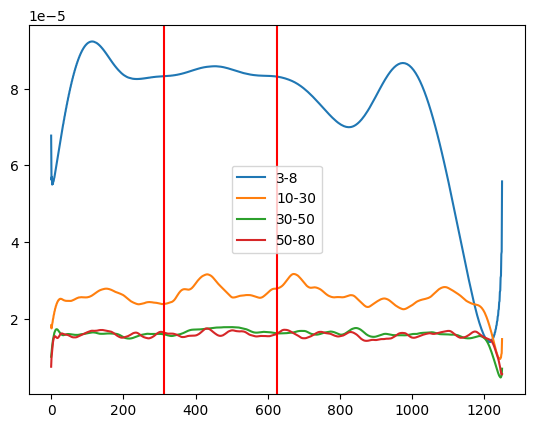

In [162]:
ac47=probeA[:,23]
bands = np.zeros((4, 200, 1250)) # 4 bands, 200 trials, 1250 time points
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
    for j, start in enumerate(stim_start):
        idx = np.arange(find_nearest_idx(ac47.time.values, start-0.25),find_nearest_idx(ac47.time.values, start+0.75))
        test = ac47.values[idx]
        test_ff = sosfiltfilt(sos, test) 
        test_env = hilbert(test_ff)
        test_env_abs = np.abs(test_env)
        if len(test_env_abs) < 1250:
            bands[i][j][:len(test_env_abs)] = test_env_abs
            bands[i][j][len(test_env_abs):] = test_env_abs[-1]
        elif len(test_env_abs) > 1250:
            bands[i][j] = test_env_abs[:1250]
        else:
            bands[i][j] = test_env_abs
avg = np.mean(bands, axis=1)
plt.plot(avg[0].T, label='3-8')
plt.plot(avg[1].T, label='10-30')
plt.plot(avg[2].T, label='30-50')
plt.plot(avg[3].T, label='50-80')
plt.axvline(250/0.8, c='r')
plt.axvline(500/0.8, c='r')
plt.legend()

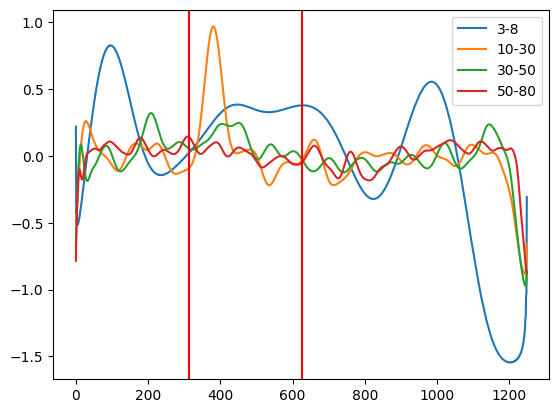

In [23]:
shared = testing(probeC, 23)

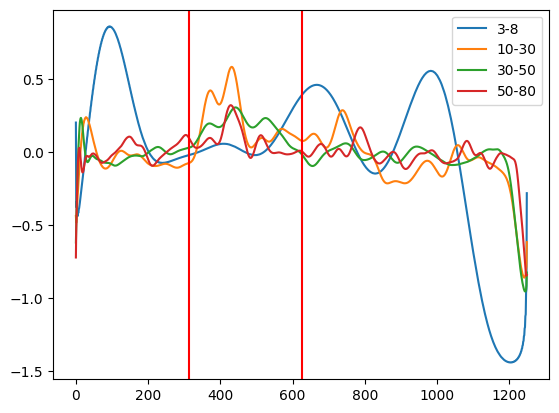

In [19]:
novel = testing(probeC, 23)

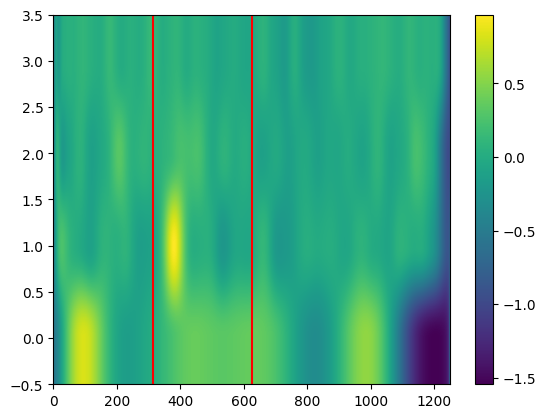

In [24]:
fig, ax = plt.subplots()
a = ax.imshow(shared, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

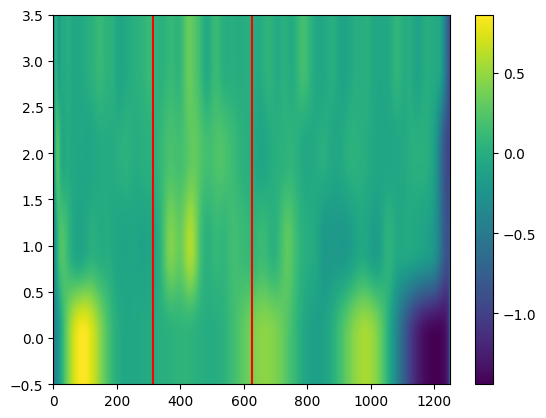

In [21]:
fig, ax = plt.subplots()
a = ax.imshow(novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

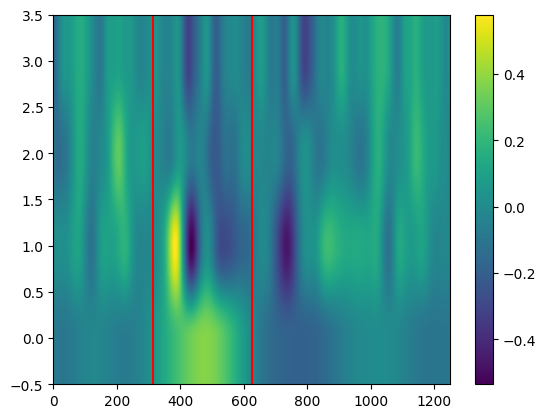

In [26]:
fig, ax = plt.subplots()
a = ax.imshow(shared-novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

##### sel and slice

In [73]:
mask = np.array([46])
A_chan = lfpA_copy[:,mask]
B_chan = lfpB_copy[:,mask]
C_chan = lfpC_copy[:,mask]
D_chan = lfpD_copy[:,mask]
E_chan = lfpE_copy[:,mask]
F_chan = lfpF_copy[:,mask]

In [24]:
print(A_chan.shape == B_chan.shape == C_chan.shape == D_chan.shape == E_chan.shape == F_chan.shape) # should all be the same

True


#### GaussianHMM

In [11]:
# plotting state
def plot(preds, num=3):
    plt.plot(preds[0:int(750*num/0.8)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/0.8, (start_time+250)/0.8, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/0.8, (start_time+500)/0.8, alpha=0.2, color='gray') # gray
        start_time += 500

In [19]:
# before padding
print(A_chan.shape)

(4503892, 3)


In [25]:
# after padding
print(A_chan.shape)

(4504304, 3)


In [74]:
#bands = np.zeros((4, 3*6, len(A_chan))) # 4 bands, 18 channels, 450k samples
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
#bands = np.reshape(bands,(4*18, len(A_chan)))
bands = np.reshape(bands,(4*6, len(A_chan)))
bands = bands[:,100:]
print(bands.shape)

(4504304, 6)
(4, 6, 4504304)


ValueError: cannot reshape array of size 108103296 into shape (72,4504304)

In [72]:
find_nearest_idx(master_time,stim.iloc[0].start_time)-100

312

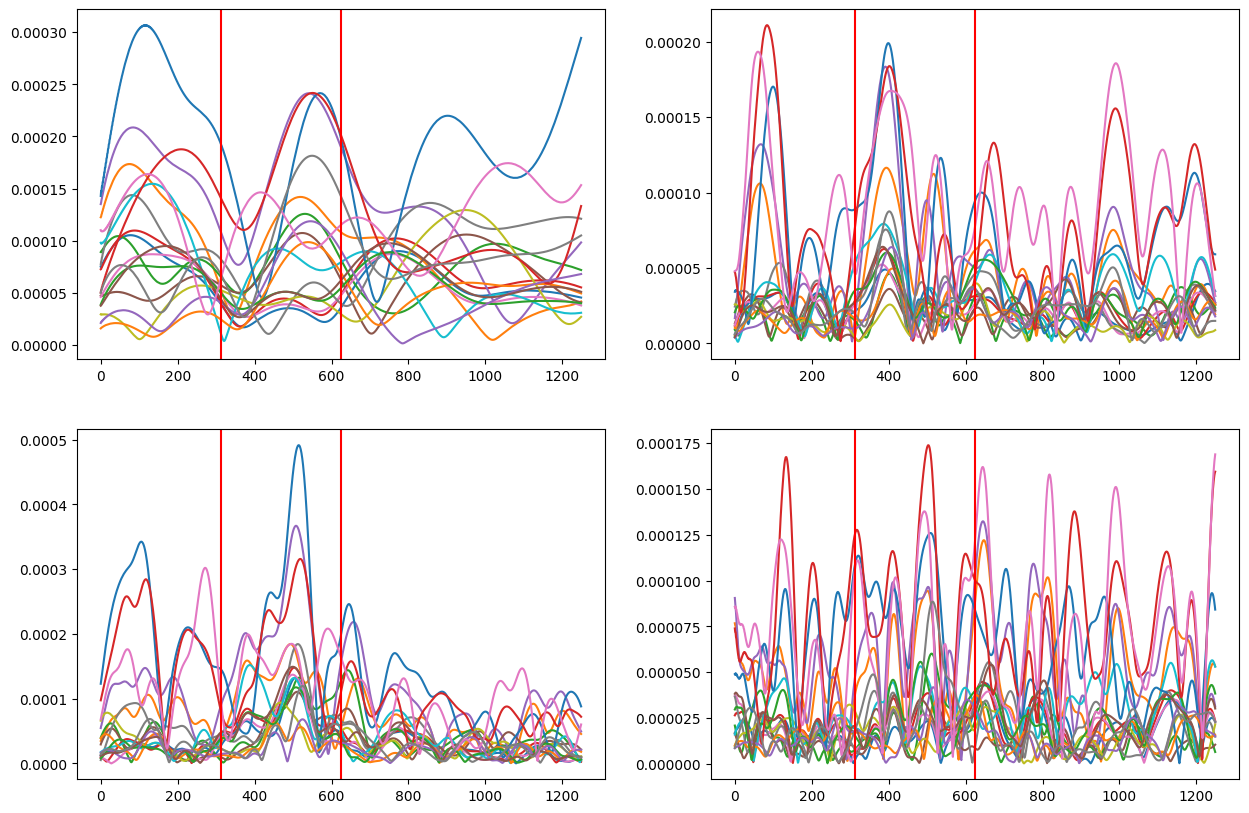

In [43]:
fig, axs=plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    for j in range(18):
        axs[i%2][i//2].plot(bands[i*18+j].T[0:1250])
    axs[i%2][i//2].axvline(250/0.8, c='r')
    axs[i%2][i//2].axvline(500/0.8, c='r')

###### sanity checks

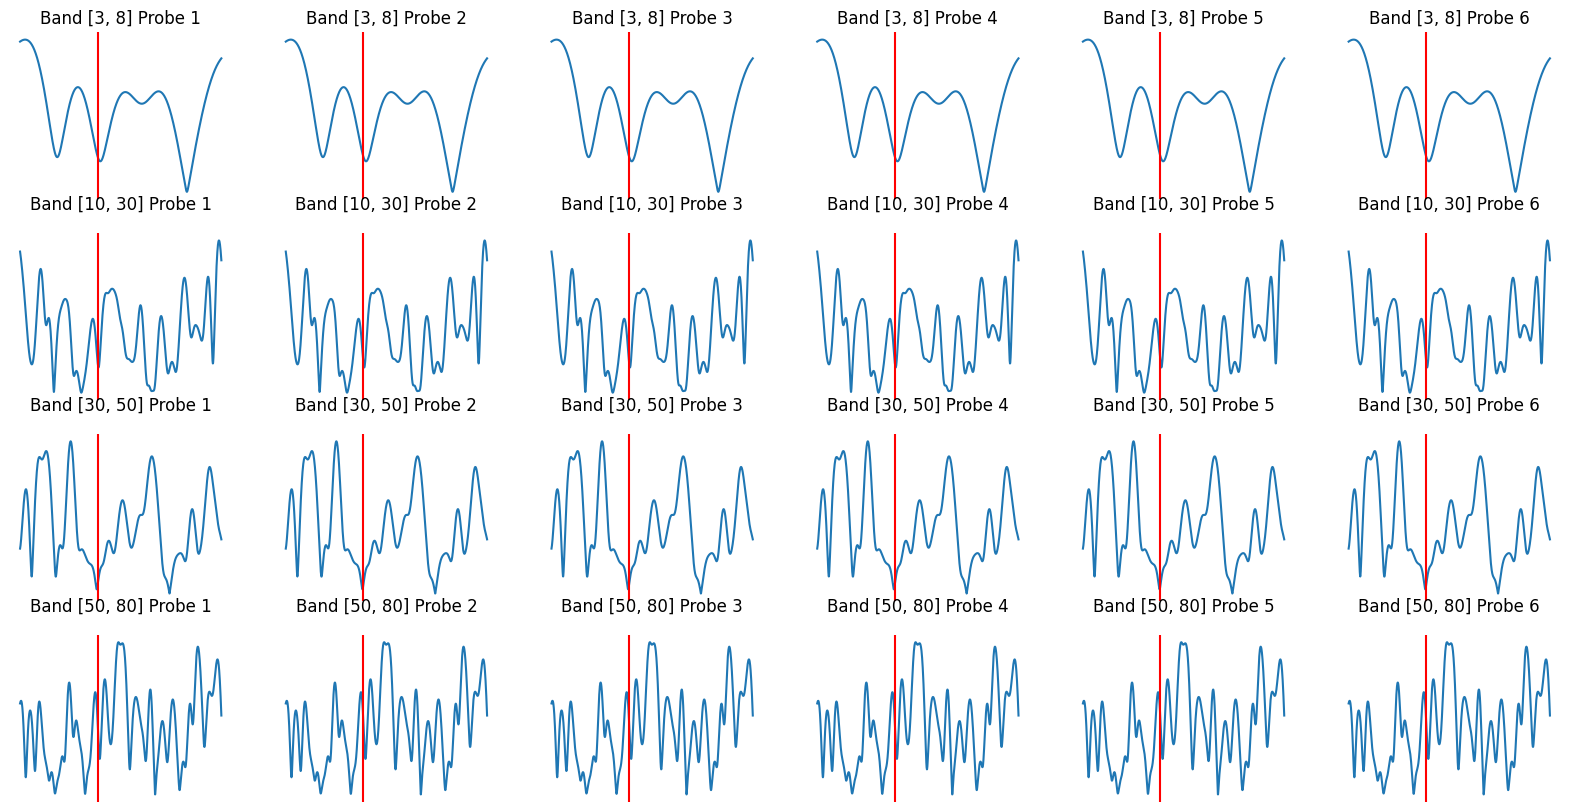

In [38]:
start = stim.iloc[3].start_time
near_idx = find_nearest_idx(probeC.time.values, [start]) # type: ignore
fig, axs = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(bands[i, j].T[near_idx-500:near_idx+800])
        axs[i, j].axvline(500, c='r')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Band {Wns[i]} Probe {j+1}')


###### end

In [54]:
bands_z = zscore(bands, axis=1)

In [65]:
bands_z_0 = zscore(bands, axis=0)

In [ ]:
model = hmm.GaussianHMM(n_components=3, n_iter=100, verbose=True, tol=0.1)
model.fit(bands.T[0:100000])
preds= model.predict(bands.T[0:100000])

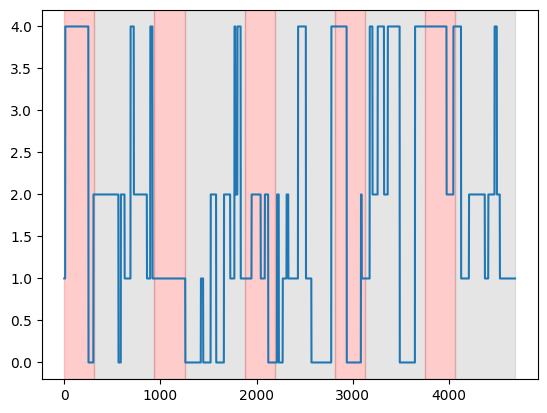

In [69]:
plot(preds, 5)

In [156]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0.T)
preds = model.predict(bands_z_0.T)

In [ ]:
m_t = master_time[100:] # to remove the 100 paddings
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,8))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
    #axs[s_idx//3][s_idx%3].bar(np.arange(8), zscore(distribution))
    #axs[s_idx//3][s_idx%3].set_title(s)

In [136]:
u_preds=preds[90:][u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]

In [145]:
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])

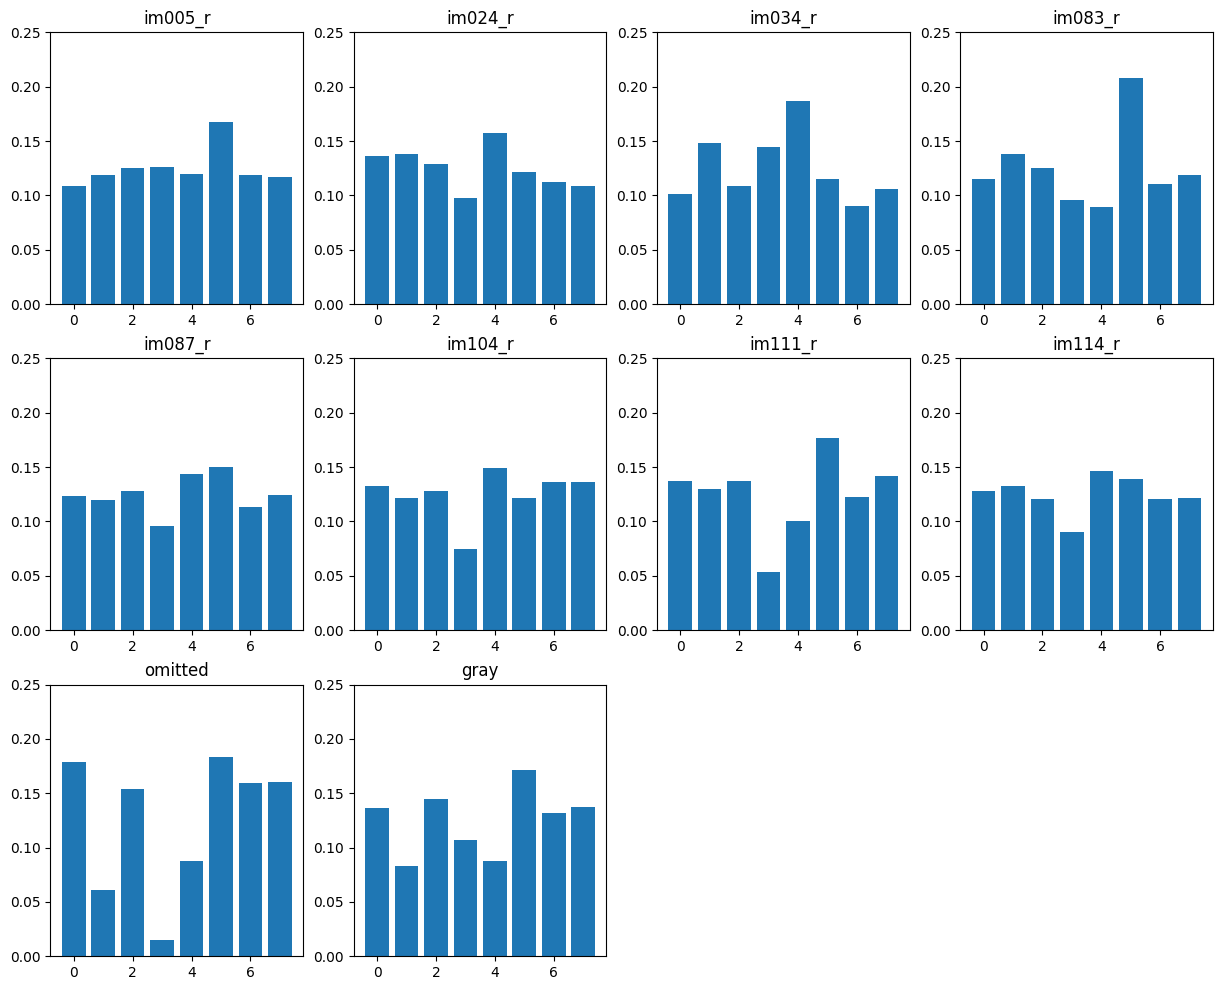

In [152]:
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(8), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.26,0.05))
        

In [155]:
file_path="E:/jerry/temp/preds/8_0x1.npz"
np.savez(file_path, preds=preds)